In [1]:
%matplotlib inline

In [2]:
import mxnet as mx
from mxnet import nd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

## 1D Fast Global Smoother
对于1D的情况，可以定义一个WLS能量函数如下
$$
J(u) = \sum_{x} ((u_x^h - f_x^h)^2 + \lambda_t \sum_{i \in N_h(x)} w_{x, i}(g^h)(u_x^h - u_i^h)^2)
$$
需要极小化这个能量函数，相当于$\Delta J(u) = 0$，可以等价于求解下面的线性系统:
$$
(I_h + \lambda_t A_h) u_h = f_h
$$
**使用下面的迭代方法**

首先计算向前方向
$$
\tilde{c_x} = c_x / (b_x - \tilde{c_{x-1}} a_x) \\
\tilde{f^h_x} = (f_x^h - \tilde{f_{x-1}^h} a_x) / (b_x - \tilde{c_{x-1}} a_x) \\
(x = 1, \cdots, W-1)
$$

然后计算向后方向
$$
u_x^h = \tilde{f^h_x} - \tilde{c_x} u_{x+1}^h \quad(x = W - 2, \cdots, 0) \\
u_{W-1}^h = \tilde{f_{W-1}^h}
$$

In [3]:
# 定义计算相似度权重函数
def cw_1d(p, q, g, sigma):
    '''
    计算1d上曲线g上不同位置p和q的相似性，使用sigma作为一个范围度量
    g: ndarray，W
    p: int
    q: int
    sigma: float
    '''
    norm = nd.norm(g[p] - g[q])
    return nd.exp(-norm/sigma)

In [4]:
# 每次迭代计算lambda
def compute_lamb(t, T, lamb_base):
    return 1.5 * 4**(T-t) / (4 ** T - 1) * lamb_base

In [5]:
# 求解一维的全局光滑线性系统
def compute_1d_fast_global_smoother(lamb, f, g, sigma, ctx):
    '''
    求解1d fast global smoother，给出lambda, f和g，进行前向和反向的递归求解
    '''
    w = f.shape[0]
    _c = nd.zeros(shape=w-1, ctx=ctx)
    _c[0] = -lamb * cw_1d(0, 1, g, sigma) / (1 + lamb * cw_1d(0, 1, g, sigma))
    _f = nd.zeros(shape=f.shape, ctx=ctx)
    _f[0] = f[0] / (1 + lamb * cw_1d(0, 1, g, sigma))
    # 递归前向计算
    for i in range(1, w-1):
        _c[i] = -lamb * cw_1d(i, i + 1, g, sigma) / (
            1 + lamb * (cw_1d(i, i - 1, g, sigma) + cw_1d(i, i + 1, g, sigma)) +
            lamb * _c[i - 1] * cw_1d(i, i - 1, g, sigma))
        _f[i] = (f[i] + _f[i - 1] * lamb * cw_1d(i, i - 1, g, sigma)) / (
            1 + lamb * (cw_1d(i, i - 1, g, sigma) + cw_1d(i, i + 1, g, sigma)) +
            lamb * _c[i - 1] * cw_1d(i, i - 1, g, sigma))
    _f[w-1] = (f[w-1] + _f[w-2] * lamb * cw_1d(w-1, w-2, g, sigma)) / (
            1 + lamb * (cw_1d(w-1, w-2, g, sigma)) +
            lamb * _c[w-2] * cw_1d(w-1, w-2, g, sigma))
    u = nd.zeros(shape=f.shape, ctx=ctx)
    u[w - 1] = _f[w - 1]
    # 递归向后计算
    for i in range(w - 2, -1, -1):
        u[i] = _f[i] - _c[i] * u[i + 1]
    return u.asnumpy()

### 完成了一维的全局光滑线性系统的求解，验证一下其是否有效

### 构造一个波动的１维输入，并画出图像

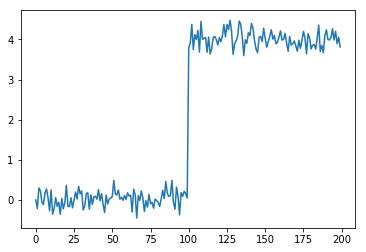

In [6]:
x1 = np.random.normal(scale=0.2, size=(100))
x2 = np.random.normal(4, 0.2, size=(100))
x = np.concatenate((x1, x2))
plt.plot(np.arange(x.shape[0]), x)

### 通过一维全局光滑线性系统的求解，得到光滑之后的图像

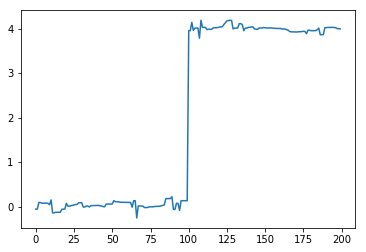

In [7]:
u = compute_1d_fast_global_smoother(900, nd.array(x, ctx=mx.gpu(0)), nd.array(x, mx.gpu(0)), 0.07, mx.gpu(0))
plt.plot(np.arange(u.shape[0]), u)

### 对于一张2D的图片，分别在水平和竖直上应用1D的solver就能够求解，在计算$w_{p, q}(g)$的时候，如果是一张RGB的图片，需要在维度为三的向量上计算相似度，但是会出现streaking artifact的问题，为了解决这个问题，在每一次的迭代中，可以修改$\lambda$的值，因为这个值在每次迭代中对稀疏光滑具有显著的减少。

In [8]:
#可分离的全局图片光滑
def Separable_global_smoother(f, T, lamb_base, sigma, ctx):
    '''
    全局图片光滑算法，输入是f和g，f是2D image, 3 channels
    '''
    print('origin lamb is {}'.format(lamb_base))
    print('sigma is {}'.format(sigma))
    H, W, C = f.shape
    u = f.copy()
    for t in range(1, T+1):
        # 计算每一步迭代的lambda_t
        lamb_t = compute_lamb(t, T, lamb_base)
        # horizontal
        for y in range(0, W):
            g = u[:, y, :]
            for c in range(C):
                f_h = u[:, y, c]
                u[:, y, c] = compute_1d_fast_global_smoother(lamb_t, f_h, g, sigma, ctx)
        # vertical
        for x in range(0, H):
            g = u[x, :, :]
            for c in range(C):
                f_v = u[x, :, c]
                u[x, :, c] = compute_1d_fast_global_smoother(lamb_t, f_v, g, sigma, ctx)
    return u

### 读入一张图片，进行multi scale manipulate

In [9]:
origin_img = Image.open('./jay.jpg')

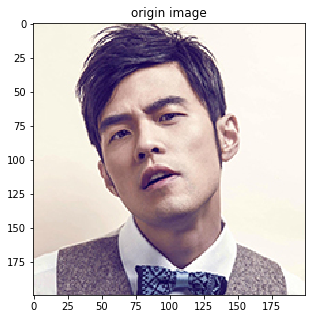

In [10]:
plt.figure(figsize=(5, 5))
plt.title('origin image')
plt.imshow(origin_img)

### 第一个尺度为100 x 100的图片，进行１～３次的迭代

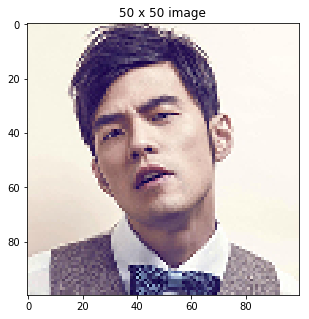

In [11]:
img_100 = origin_img.resize((100, 100))
plt.figure(figsize=(5, 5))
plt.title('50 x 50 image')
plt.imshow(img_100)

In [12]:
lamb_base = 30**2
sigma = 255 * 0.03
ctx = mx.gpu(0)
img = np.array(img_100)
img = nd.array(img, ctx=ctx)

一次迭代的结果

origin lamb is 900
sigma is 7.6499999999999995


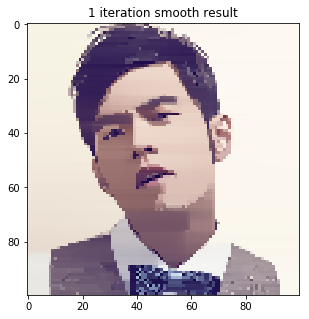

In [13]:
T = 1
u1 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u1.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('1 iteration smooth result')
plt.imshow(show_u)

二次迭代

origin lamb is 900
sigma is 7.6499999999999995


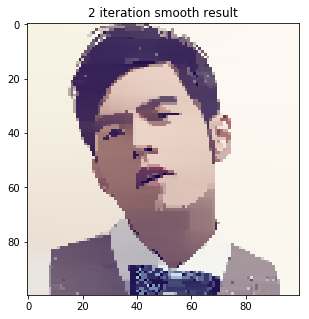

In [14]:
T = 2
u2 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u2.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('2 iteration smooth result')
plt.imshow(show_u)

三次迭代

origin lamb is 900
sigma is 7.6499999999999995


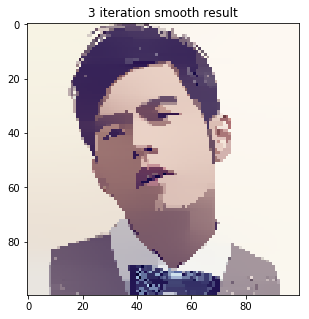

In [15]:
T = 3
u3 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u3.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('3 iteration smooth result')
plt.imshow(show_u)

### 对原始图片做global fast smooth

In [16]:
lamb_base = 30**2
sigma = 255 * 0.03
ctx = mx.gpu(0)
img = np.array(origin_img)
img = nd.array(img, ctx=ctx)

一次迭代

origin lamb is 900
sigma is 7.6499999999999995


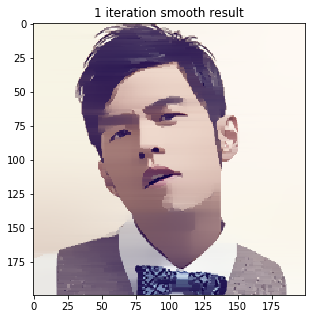

In [17]:
T = 1
u1 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u1.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('1 iteration smooth result')
plt.imshow(show_u)

二次迭代

origin lamb is 900
sigma is 7.6499999999999995


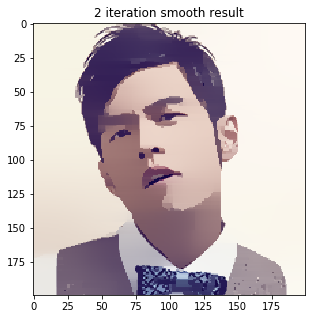

In [18]:
T = 2
u2 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u2.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('2 iteration smooth result')
plt.imshow(show_u)

三次迭代

origin lamb is 900
sigma is 7.6499999999999995


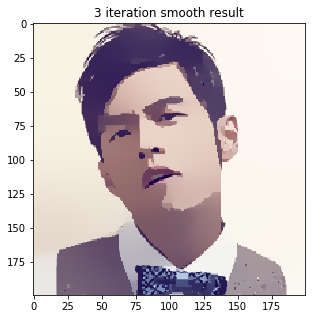

In [19]:
T = 3
u3 = Separable_global_smoother(img, T, lamb_base, sigma, ctx)
show_u = u3.astype('uint8').asnumpy()
plt.figure(figsize=(5, 5))
plt.title('3 iteration smooth result')
plt.imshow(show_u)